### **Galaxy Selection and 2D Projections:**

#### **Import Files and Setup Configuration:**

**Note:** This notebook currently has the small catalog activated so that it runs faster, but actual analysis should use the full catalog to account for periodic boundary conditions and to include the entire Gaussian fit over the Z positions.

In [1]:
import GCRCatalogs
import numpy as np

import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import seaborn as sns
from scipy.constants import speed_of_light
from scipy.interpolate import make_interp_spline
import scipy.stats
import pyccl
import sys

sns.set(style = "ticks")
pi = np.pi

%config IPCompleter.greedy = True
%config InlineBackend.figure_format ='retina'

# Load Appropriate Catalog
cat = GCRCatalogs.load_catalog("baseDC2_snapshot_z0.15_v0.1_small")
#cat = GCRCatalogs.load_catalog("baseDC2_snapshot_z0.15_v0.1")


#### **Load Position Data and Apply Preliminary Cuts:**

Load the data appropriately depending on user-defined cuts. X and Y positions are cut equally to define a square 2D grid (position data limits are listed below). Additionally, removes all galaxies with $r_{mag} > 24.5$.

**Small Catalog Limits\*:**

| X | Y | Z |
| --- | --- | --- |
| [0, 354.7] | [0, 425.0] | [0, 846.5] |

**Full Catalog Limits:**

| X | Y | Z |
| --- | --- | --- |
| [0, 4231.7] | [0, 4232.25] | [0, 4231.6] |

\* The small catalog has 40 positional entries with X, Y, or Z around 4000 Mpc, but after removing these entries, the above boundaries are identified.

In [2]:
# Initialize/Load Cosmology Parameters
z_red_shift = cat.redshift
cosmo = cat.cosmology

# Box bounds (Mpc/h)
min_z = 0
max_z = 750
min_x_y = 0
max_x_y = 350

cat_quantities = cat.get_quantities(["position_x", "position_y", "position_z", 
                                     "Mag_true_r_lsst_z0"], 
                                    filters=["position_z > {}".format(min_z), 
                                             "position_z < {}".format(max_z), 
                                             "position_x < {}".format(max_x_y),
                                             "position_x > {}".format(min_x_y),
                                             "position_y < {}".format(max_x_y),
                                             "position_y > {}".format(min_x_y)])

x_data = cat_quantities["position_x"]
y_data = cat_quantities["position_y"]
z_data = cat_quantities["position_z"]
r_Mag = cat_quantities["Mag_true_r_lsst_z0"]

# Convert absolute to apparent magnitude
r_mag = r_Mag+cosmo.distmod(z_red_shift).value  
filtered_indices = np.where(r_mag < 24.5)[0]

# Clear magnitude arrays
del r_mag
del r_Mag

x_data = x_data[filtered_indices]
y_data = y_data[filtered_indices]
z_data = z_data[filtered_indices]

#### **Filter Position Data with Gaussian Kernel:**

Apply a Gaussian kernel to the z position data and then select galaxies acccording to a Gaussian kernel defined as $e^{-\frac{(z-\bar{z})^2}{2\sigma_\chi^2}}$, where $\bar{z}$ is the average z position, $\sigma_\chi = \frac{c}{H(z)}\sigma_z,$ and $\sigma_z \approx 0.05(1+z_{redshift})$.

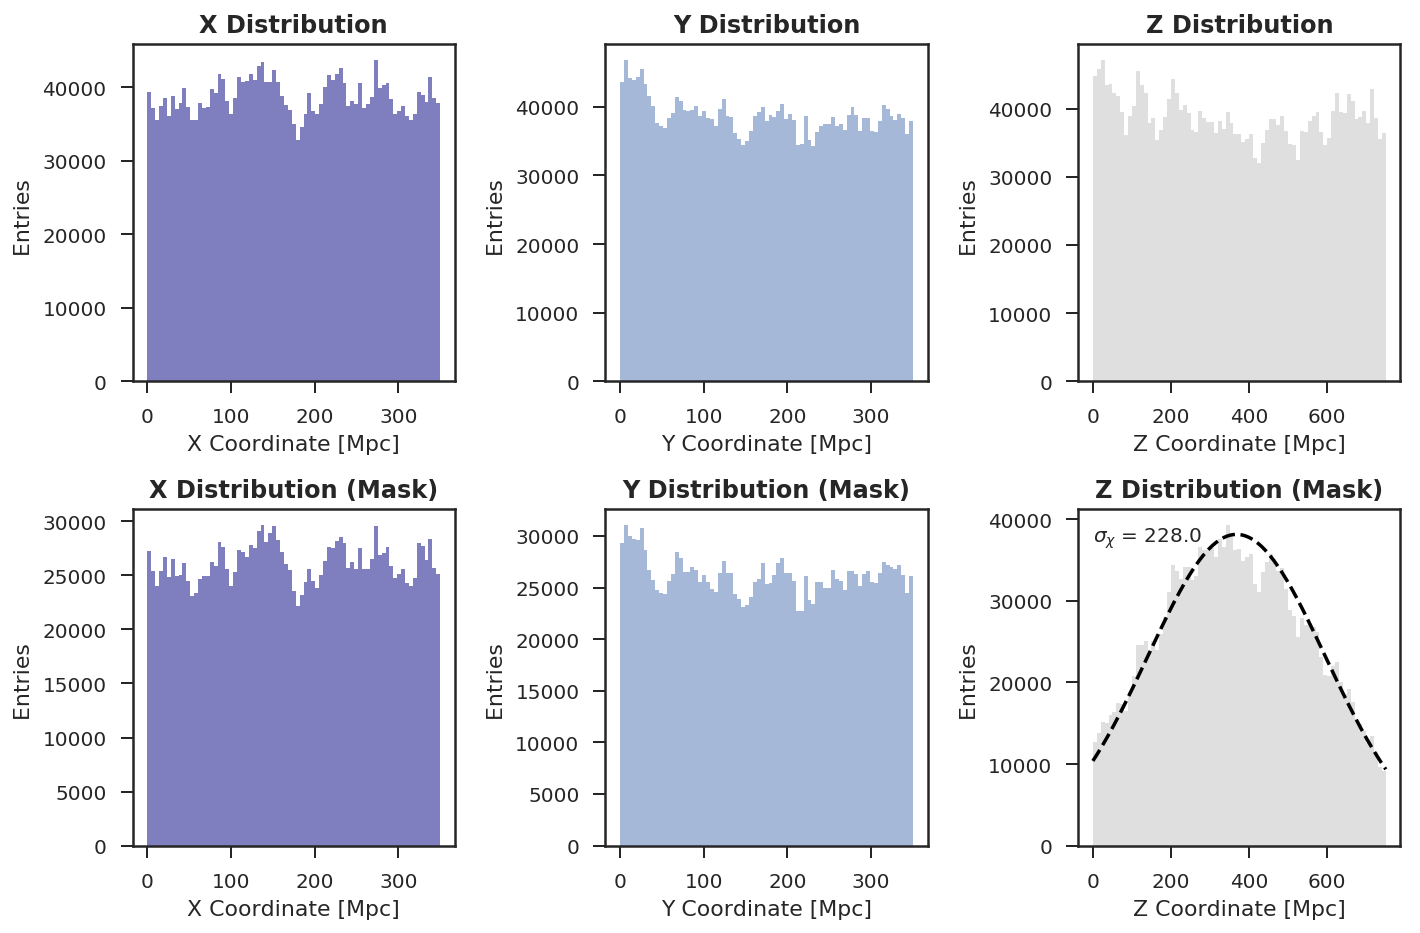

In [3]:
# Compute standard deviations for establishing Gaussian
sigma_z = 0.05*(1+z_red_shift)
H_z = cosmo.H(z_red_shift).value
c_km_s = speed_of_light/10**3 # speed of light in km/s
sigma_chi = c_km_s/H_z*sigma_z
n_g = len(x_data) #number of galaxies

# Apply Gaussian kernel
z_bar = np.mean(z_data)
cutoffs = np.random.uniform(0, 1, len(z_data))

mask_ind = np.where(cutoffs < np.exp(-(z_data-z_bar)**2/(2*sigma_chi**2)))[0]

x_masked = x_data[mask_ind]
y_masked = y_data[mask_ind]
z_masked = z_data[mask_ind]

x_width = max_x_y-min_x_y
y_width = max_x_y-min_x_y

#----------------------------Begin Plotting----------------------------#
# Plot masked and unmasked histograms
fig = plt.figure(figsize=(10,6.6))
n_bins = 75

plt.subplot(2,3,1)
plt.hist(x_data, bins = n_bins, alpha  = 0.5, color = "navy")
plt.title("X Distribution", fontweight = "bold")
plt.xlabel("X Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2,3,2)
plt.hist(y_data, bins = n_bins, alpha = 0.5);
plt.title("Y Distribution", fontweight = "bold")
plt.xlabel("Y Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2,3,3)
plt.hist(z_data, bins = n_bins, alpha = 0.5, color = "silver");
plt.title("Z Distribution", fontweight = "bold")
plt.xlabel("Z Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2,3,4)
plt.hist(x_masked, bins = n_bins, alpha  = 0.5, color = "navy")
plt.title("X Distribution (Mask)",fontweight = "bold")
plt.xlabel("X Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2,3,5)
plt.hist(y_masked, bins = n_bins, alpha = 0.5);
plt.title("Y Distribution (Mask)", fontweight = "bold")
plt.xlabel("Y Coordinate [Mpc]")
plt.ylabel("Entries ")

plt.subplot(2,3,6)
plt.hist(z_masked, bins = n_bins, alpha = 0.5, color = "silver");
plt.title("Z Distribution (Mask)", fontweight = "bold")
plt.xlabel("Z Coordinate [Mpc]")
plt.ylabel("Entries ")
ax_max = max(plt.ylim())
sigma_chi_str = "$\sigma_\chi$ = {}".format(np.round(sigma_chi, 1))
plt.text(0.5 , 0.95*ax_max, sigma_chi_str,fontsize=10,
        verticalalignment='top',)

# Overlay Gaussian
z_gaussian = np.linspace(min_z, max_z, 200)
exp_z = 1/(np.sqrt(2*pi)*sigma_chi)*np.exp(-(z_gaussian-z_bar)**2/(2*sigma_chi**2))

bin_width = (max_z - min_z)/n_bins

# Rescale by accounting for the fact that the data do not fulfill the entire Gaussian 
# and by multiplying the normalized pdf by bin_width*len(data)

std_offset = (max_z-min_z)/(2*sigma_chi)
rel_area = scipy.stats.norm.cdf(std_offset)-scipy.stats.norm.cdf(-std_offset)
exp_z *= (bin_width*len(z_masked))/rel_area

plt.plot(z_gaussian, exp_z, '--', color = 'k')

plt.tight_layout()
#-----------------------------End Plotting-----------------------------#

#### **Compute 2D Power Spectrum Projections:**

Construct2 2D power spectrum from theoretical models using the following procedure:

1. Define the power spectrum $P(k_\parallel, k_\perp)$ using the linear matter p
ower spectrum function in pyCCL
2. Integrate over a range of values for $k_\perp$ using the integral defined below to obtain a theoretical estimate for the 2D power spectrum
$$P(k_\perp) = \frac{b^2}{2\pi}\int\limits_{0}^{\infty}P(k_\parallel, k_\perp)e^{-k_\parallel^2\sigma_\chi^2}dk_\parallel$$

In [4]:
# Configure bias term
b_2 = 1.7

n_bar = n_g/(x_width*y_width)

#Initialize a PyCCL cosmology object 
cosmo_ccl = pyccl.Cosmology(h = cosmo.h, sigma8 = cosmo.sigma8, 
                            Omega_g = cosmo.Ogamma0, Omega_k = cosmo.Ok0, 
                            Omega_c =  cosmo.Odm0, Omega_b = cosmo.Ob0, 
                            n_s = cosmo.n_s, Neff = cosmo.Neff)

def integrand_function(k_par, k_perp, cosmo_ccl, cosmo, z, sigma_chi, linear):


    if linear:
        P_k = pyccl.linear_matter_power(cosmo_ccl, np.sqrt(k_perp**2+k_par**2), 
                                    cosmo.scale_factor(z))
    else:
        P_k = pyccl.nonlin_matter_power(cosmo_ccl, np.sqrt(k_perp**2+k_par**2), 
                                    cosmo.scale_factor(z))
        
    return P_k*np.exp(-(k_par*sigma_chi)**2)


integrator = np.vectorize(lambda k_perp: 1/(2*pi)*scipy.integrate.quad(
    integrand_function, 0, 0.3, args=(k_perp, cosmo_ccl, cosmo, 
                                      z_red_shift, sigma_chi, True))[0])

integrator_nl = np.vectorize(lambda k_perp: 1/(2*pi)*scipy.integrate.quad(
    integrand_function, 0, 0.3, args=(k_perp, cosmo_ccl, cosmo, 
                                      z_red_shift, sigma_chi, False))[0])

def get_pow_2d(k_perp, integrator):
    return b_2*integrator(k_perp)+1/n_bar

#### **Plot 2D Power-Spectrum Models:**

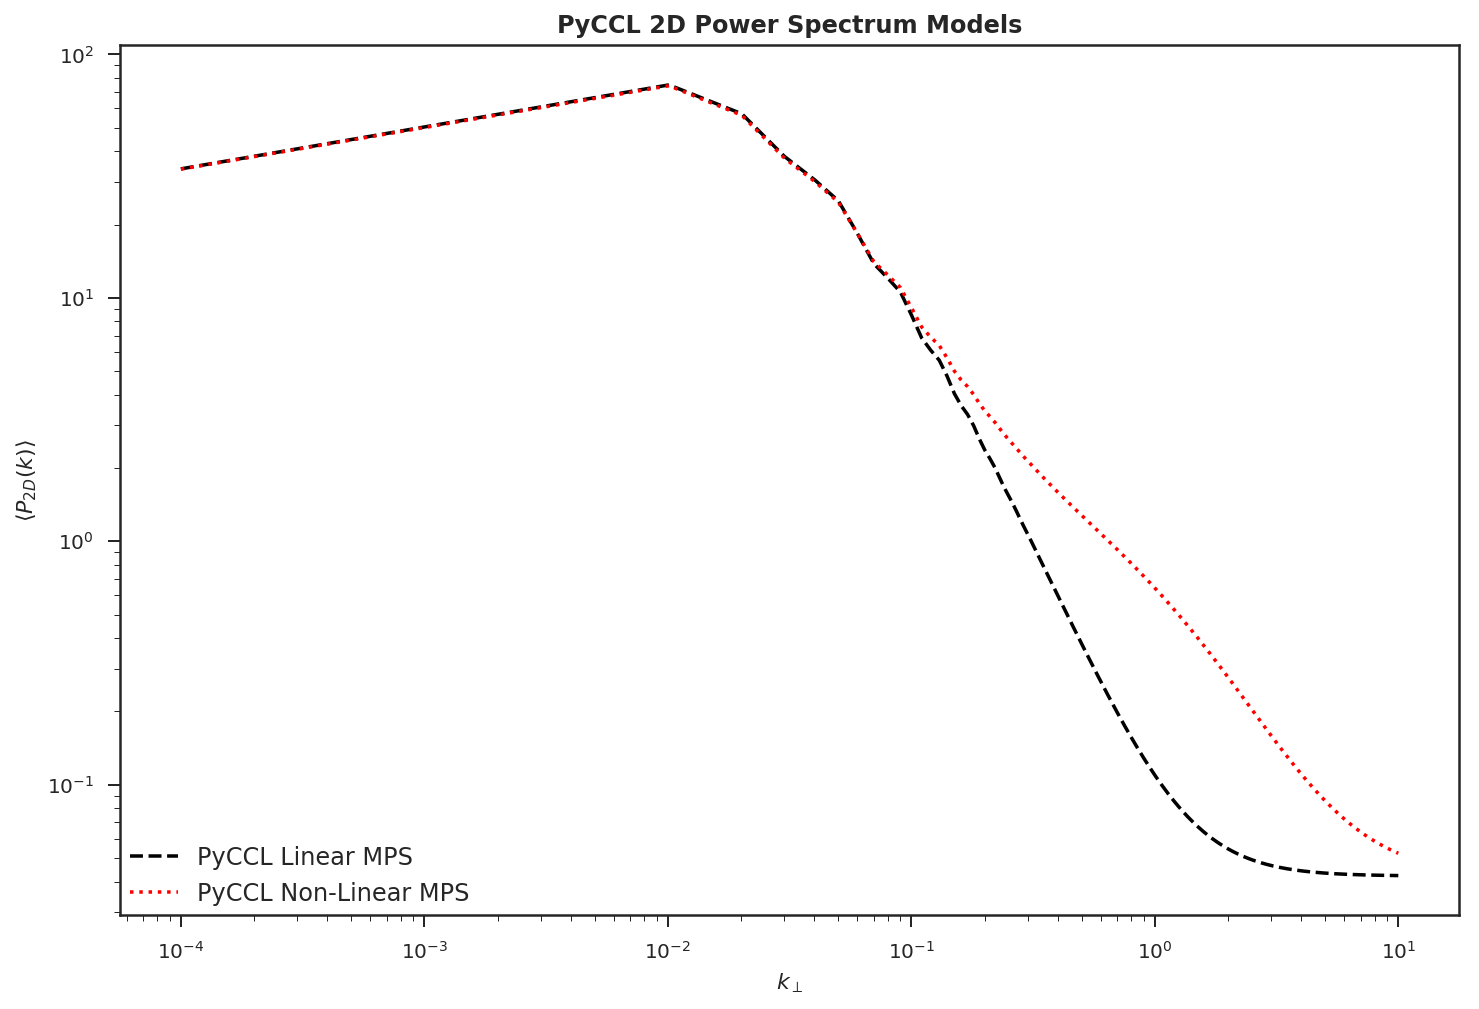

In [7]:
k_2 = np.linspace(1e-4, 10, 1000)


# Plot data for 2D linear and non-linear full range approx.
plt.figure(figsize = (12,8))
plt.plot(k_2, get_pow_2d(k_2, integrator), color = "k",  linestyle  = "dashed",
         label = "PyCCL Linear MPS")
plt.plot(k_2, get_pow_2d(k_2, integrator_nl), color = "r" , linestyle = ":",
         label = "PyCCL Non-Linear MPS")

plt.title("PyCCL 2D Power Spectrum Models", fontweight = "bold")
plt.xlabel(r"$k_\perp$")
plt.ylabel(r"$\left\langle P_{2D}(k)\right\rangle$")
plt.legend(loc = (0, 0), fontsize = 12) 
plt.xscale("log")
plt.yscale("log")